In [135]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Questão 1

In [136]:
def exact_solution(x, k):
    """Solução exata p(x) = cos(k x) (parte real da solução analítica)."""
    return np.cos(k * x)

def tridiag_solve(sub, main, sup, rhs):
    """
    Resolve sistema tridiagonal Ax = rhs usando algoritmo de Thomas.
    """
    n = len(main)
    
    # Cópias para evitar modificar originais
    a = sub.copy()
    b = main.copy()
    c = sup.copy()
    d = rhs.copy()
    
    # Eliminação forward
    for i in range(1, n):
        if b[i-1] == 0:
            return np.full(n, np.nan)  # Evitar divisão por zero
        factor = a[i-1] / b[i-1]
        b[i] -= factor * c[i-1]
        d[i] -= factor * d[i-1]
    
    # Substituição back
    x = np.zeros(n)
    if b[-1] == 0:
        return np.full(n, np.nan)
    x[-1] = d[-1] / b[-1]
    for i in range(n-2, -1, -1):
        x[i] = (d[i] - c[i] * x[i+1]) / b[i]
    
    return x    

def finite_differences_helmholtz(k, a, b, N, dtype=np.float64):
    """
    Método de diferenças finitas para o problema de Helmholtz.
    """
    h = (b - a) / N
    x = np.linspace(a, b, N + 1, dtype=dtype)
    
    # Parâmetros do sistema tridiagonal
    n = N - 1
    sub = -np.ones(n - 1)
    main = (2 - k**2 * h**2) * np.ones(n)
    sup = -np.ones(n - 1)
    
    alpha = exact_solution(a, k).astype(dtype) 
    beta  = exact_solution(b, k).astype(dtype) 
    
    rhs = np.zeros(n, dtype=dtype)
    rhs[0] = alpha
    rhs[-1] = beta
    
    # Checa diagonal dominante 
    tol = 1e-15
    if np.any(np.abs(main) < tol):
        # sinaliza instabilidade
        return x, None, h  
    
    # Resolver usando Thomas
    p_int = tridiag_solve(sub, main, sup, rhs)
    
    if p_int is None:
        return x, None, h
    
    # Montar solução completa
    p_approx = np.zeros(N + 1)
    p_approx[0] = alpha
    p_approx[1:-1] = p_int
    p_approx[-1] = beta
    
    return x, p_approx, h

In [137]:
def compute_convergence_data(k_values, a, b, N_list, exact_solution_func, kh_threshold=1.0):
    """
    Calcula erros máximos (||e||_inf) e ajusta uma reta log-log para estimar ordem de convergência p.
    """
    h_list = [(b - a) / N for N in N_list]
    errors = {k: [] for k in k_values}
    rates = {}
    
    for k in k_values:
        for N in N_list:
            x, p_approx, h = finite_differences_helmholtz(k, a, b, N)
            
            if p_approx is None:
                errors[k].append(np.nan)
                continue
            
            p_ex = exact_solution_func(x, k)
            error = np.max(np.abs(p_approx - p_ex))
            errors[k].append(error)
        
        h_arr = np.array(h_list)
        err_arr = np.array(errors[k])
        valid_mask = (~np.isnan(err_arr)) & (k * h_arr < kh_threshold)
        
        if np.sum(valid_mask) > 1:
            slope = np.polyfit(np.log(h_arr[valid_mask]), np.log(np.maximum(err_arr[valid_mask], 1e-16)), 1)[0]
            rates[k] = slope
        else:
            rates[k] = np.nan

    return h_list, errors, rates

In [138]:
def plot_solution_comparison(k, a, b, N_list_selected, title_prefix, filename_prefix):
    """
    Gera gráficos comparativos de p(x) exata vs. aproximada para diferentes N (e h).
    """
    for N in N_list_selected:
        x, p_approx, h = finite_differences_helmholtz(k, a, b, N)
        p_ex = exact_solution(x, k)
        kh = k * h
        
        plt.figure(figsize=(8, 6))
        plt.plot(x, p_ex, 'k-', linewidth=2.0, label='Solução Exata')
        plt.plot(x, p_approx, 'r--', linewidth=1.5, label=f'Aproximada (N={N}, h={h:.4f}, kh={kh:.4f})')
        plt.xlabel('x', fontsize=12)
        plt.ylabel('p(x)', fontsize=12)
        plt.title(f'{title_prefix} para k={k}, N={N}', fontsize=14, weight='bold')
        plt.grid(True, which='both', ls='--', lw=0.5)
        plt.legend(fontsize=10)
        plt.tight_layout()
        filename = f'{filename_prefix}_k{k}_N{N}.png'
        # plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

def plot_convergence(h_list, errors, rates, title, filename=None, show=True):
    """
    Gera gráfico log-log de convergência para diferentes k.
    """
    plt.figure(figsize=(8, 6))
    
    # converter h para array crescente 
    h_arr = np.array(h_list, dtype=float)

    # reunir todos os erros válidos (ignora NaN e zeros)
    all_errors = []
    for err_list in errors.values():
        for e in err_list:
            if e is None: 
                continue
            try:
                if not (np.isnan(e) or e == 0.0):
                    all_errors.append(float(e))
            except:
                pass

    # plot das curvas por k
    for k, error_list in errors.items():
        err_arr = np.array(error_list, dtype=float)
        # evitar plotar valores NaN 
        valid_mask = ~np.isnan(err_arr)
        if np.any(valid_mask):
            p = rates.get(k, None)
            label = f'$k={k}$' + (f' (p ≈ {p:.2f})' if p is not None and not np.isnan(p) else '')
            plt.loglog(h_arr[valid_mask], err_arr[valid_mask], 'o--', linewidth=1.3, markersize=6, label=label)

    if len(all_errors) > 0:
        h_min = h_arr.min()
        min_err = min(all_errors)

        # proteger contra min_err == 0
        if min_err <= 0:
            min_err = max([e for e in all_errors if e > 0], default=None)

        if min_err is not None:
            C = min_err / (h_min**2)
            # criar vetor de h para a linha de referência (entre min e max)
            h_ref = np.logspace(np.log10(h_arr.min()), np.log10(h_arr.max()), 200)
            plt.loglog(h_ref, C * (h_ref**2), 'k:', linewidth=1.2, label=r'Referência $O(h^2)$')

    plt.xlabel('$h$ (passo espacial)', fontsize=12)
    plt.ylabel(r'Erro máximo $\|e\|_\infty$', fontsize=12)
    plt.title(title, fontsize=14, weight='bold')
    plt.grid(True, which='both', ls='--', lw=0.5)
    plt.legend(fontsize=10)
    plt.tight_layout()

    # if filename:
    #     plt.savefig(filename, dpi=450, bbox_inches='tight')
    if show:
        plt.show()
    else:
        plt.close() 

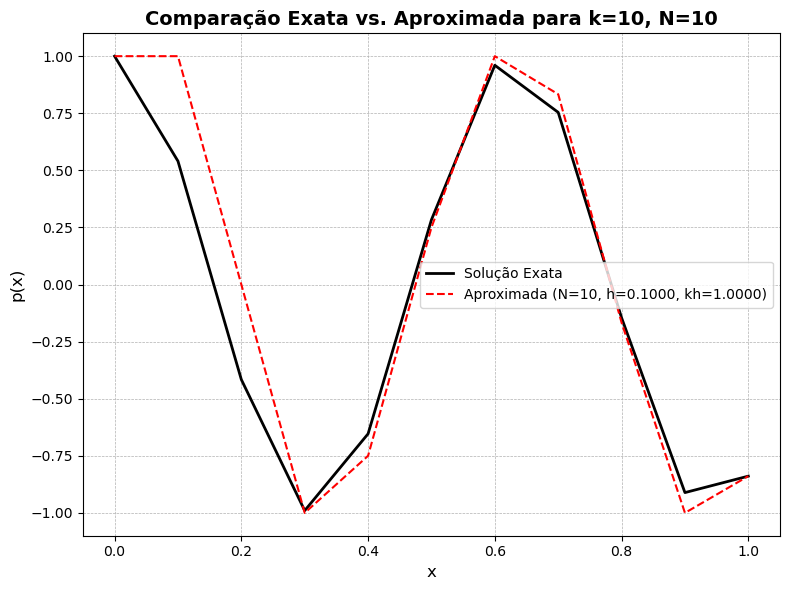

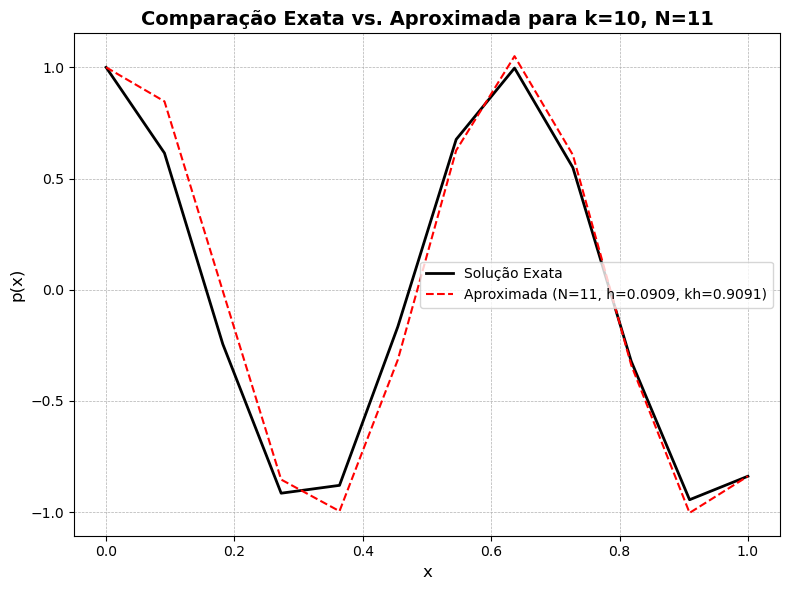

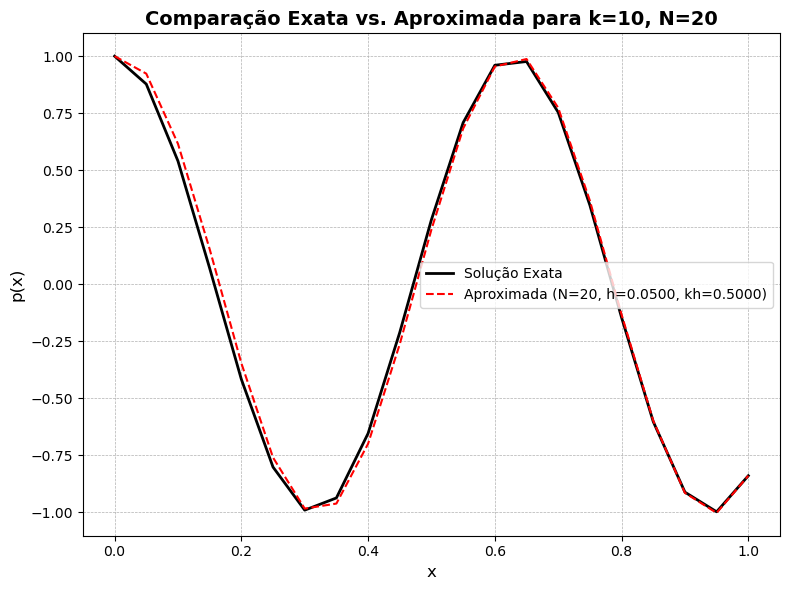

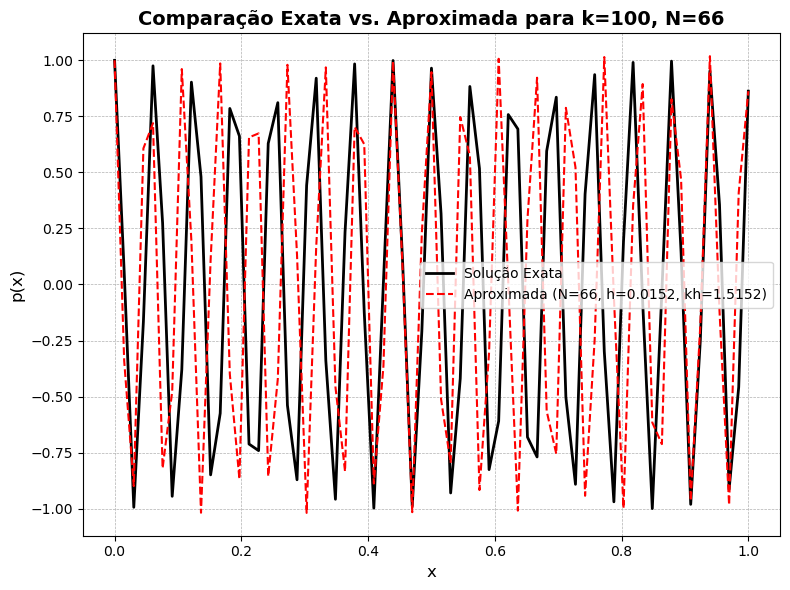

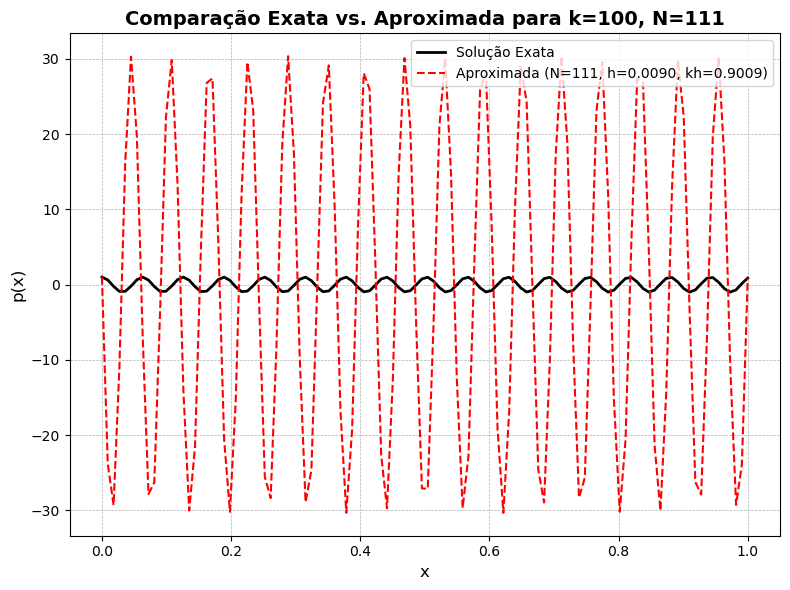

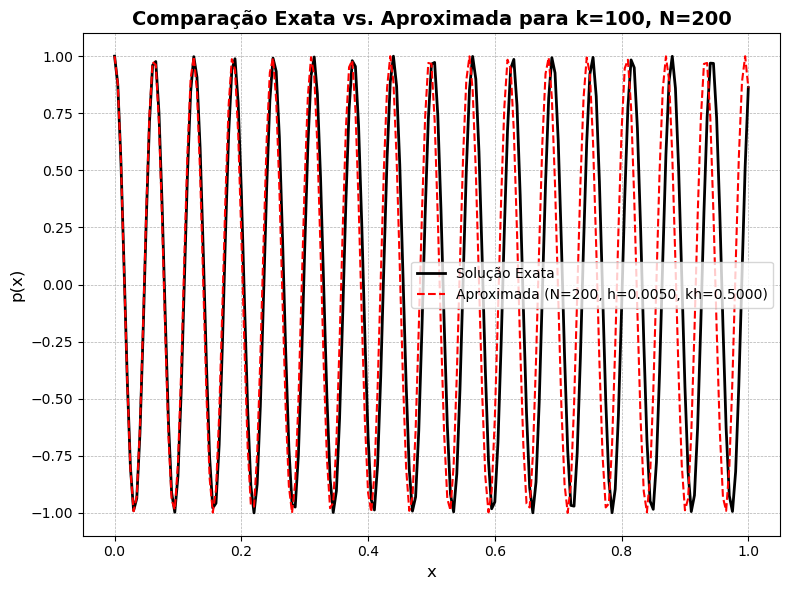

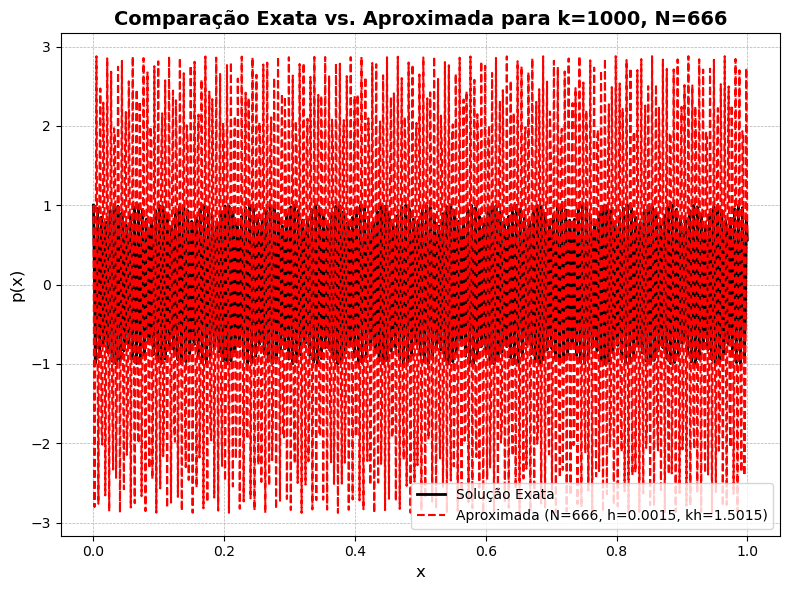

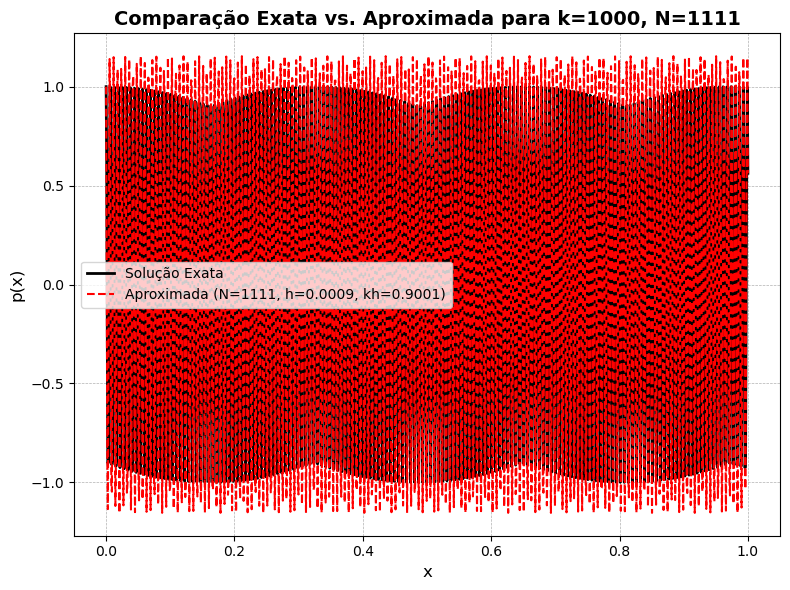

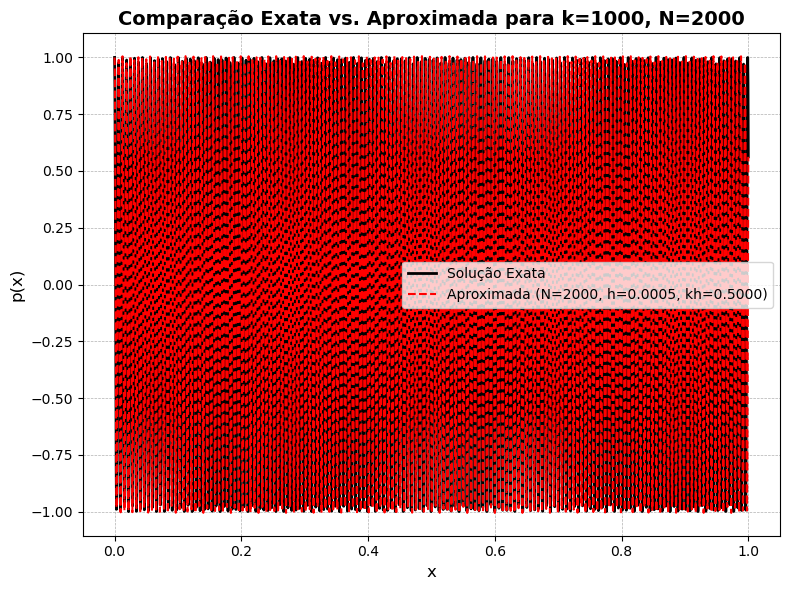

In [139]:
a = 0.0
b = 1.0
k_values = [10, 100, 1000]

# Ajuste N_list para convergência 
N_list = [2**j for j in range(5, 18)]  # 2**5 a 2**18

# Item a): Validação kh<1 com comparações
for k in k_values:
    h_target_good = 0.5 / k
    N_good = max(10, int((b - a) / h_target_good))
    h_target_limit = 0.9 / k  # <1 para evitar exato=1
    N_limit = max(10, int((b - a) / h_target_limit))
    h_target_bad = 1.5 / k
    N_bad = max(10, int((b - a) / h_target_bad))
    
    N_selected = [N_bad, N_limit, N_good]
    
    plot_solution_comparison(k, a, b, N_selected, 
                             title_prefix='Comparação Exata vs. Aproximada',
                             filename_prefix='validation')


Tabela de Erros e kh para diferentes N e k (Item a):
     N  Erro k=10   kh k=10  Erro k=100  kh k=100  Erro k=1000  kh k=1000
    32  3.351e-02 3.125e-01   9.975e-01 3.125e+00    9.999e-01  3.125e+01
    64  8.572e-03 1.562e-01   2.378e+00 1.562e+00    9.999e-01  1.562e+01
   128  2.154e-03 7.812e-02   2.343e+00 7.812e-01    9.999e-01  7.812e+00
   256  5.394e-04 3.906e-02   1.737e+00 3.906e-01    1.000e+00  3.906e+00
   512  1.349e-04 1.953e-02   1.891e-01 1.953e-01    2.782e+00  1.953e+00
  1024  3.373e-05 9.766e-03   4.062e-02 9.766e-02    2.228e+00  9.766e-01
  2048  8.432e-06 4.883e-03   9.867e-03 4.883e-02    2.070e+00  4.883e-01
  4096  2.108e-06 2.441e-03   2.450e-03 2.441e-02    5.729e+00  2.441e-01
  8192  5.270e-07 1.221e-03   6.115e-04 1.221e-02    5.861e-01  1.221e-01
 16384  1.318e-07 6.104e-04   1.528e-04 6.104e-03    1.487e-01  6.104e-02
 32768  3.297e-08 3.052e-04   3.820e-05 3.052e-03    3.826e-02  3.052e-02
 65536  8.136e-09 1.526e-04   9.549e-06 1.526e-03    9.655

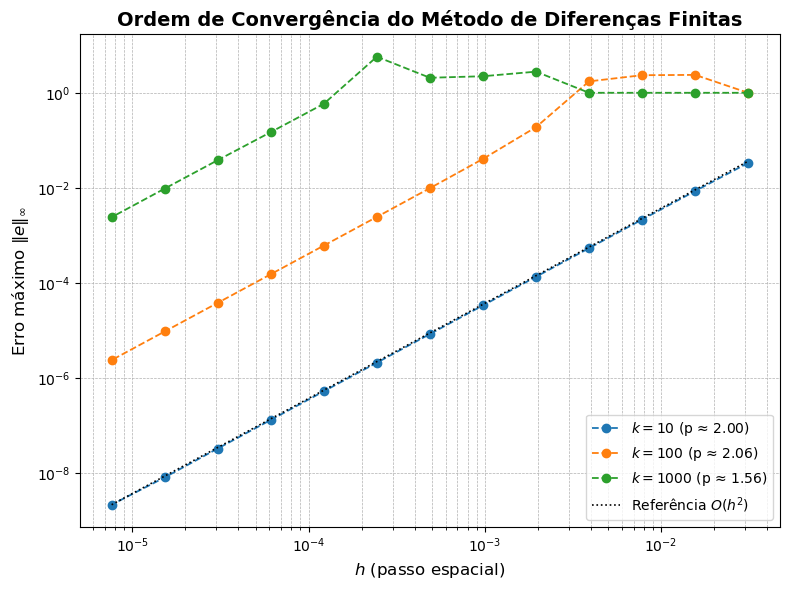

In [140]:
# Calculando os erros
errors_df = pd.DataFrame({"N": N_list})
h_list = [(b - a) / N for N in N_list]

for k in k_values:
    errors = []
    kh_values = []
    for N in N_list:
        x, p_approx, h = finite_differences_helmholtz(k, a, b, N)
        p_ex = exact_solution(x, k)
        error = np.max(np.abs(p_approx - p_ex))
        errors.append(error)
        kh_values.append(k * h)
    errors_df[f'Erro k={k}'] = errors
    errors_df[f'kh k={k}'] = kh_values

print("\nTabela de Erros e kh para diferentes N e k (Item a):")
print(errors_df.to_string(index=False, float_format="%.3e"))


h_list, errors, rates = compute_convergence_data(k_values, a, b, N_list, exact_solution)

print("\nTaxas de convergência estimadas (ajuste log-log) para diferentes k (Item b):")
for k, rate in rates.items():
    print(f"k={k:<4} p ≈ {rate:.4f}")

plot_convergence(h_list, errors, rates, 
                 title='Ordem de Convergência do Método de Diferenças Finitas',
                 filename='convergence_order.png', show=True)

# Questão 2

In [141]:
eps=1e-2
kappa=1.0

In [142]:
def exact_solution(x, eps=eps, kappa=kappa):

    A = -eps / kappa
    B = 1.0 - A * np.exp(-kappa / eps)
    return A * np.exp(-kappa / eps * x) + B


def tridiag_solve(sub, main, sup, rhs):

    n = len(main)
    a = sub.copy()
    b = main.copy()
    c = sup.copy()
    d = rhs.copy()
    
    # Eliminação para frente
    for i in range(1, n):
        w = a[i-1] / b[i-1]
        b[i] = b[i] - w * c[i-1]
        d[i] = d[i] - w * d[i-1]
    
    # Substituição para trás
    x = np.zeros(n)
    x[-1] = d[-1] / b[-1]
    for i in range(n-2, -1, -1):
        x[i] = (d[i] - c[i] * x[i+1]) / b[i]
    
    return x

In [143]:
def assemble_system(N, convective='central', eps=1e-2, kappa=1.0, debug=False):

    h = 1.0 / N
    x = np.linspace(0.0, 1.0, N+1)
    n = N + 1

    A = np.zeros((n, n))
    f = np.zeros(n)

    # --- Difusão artificial 
    gamma = 0.0
    if convective == 'artificial':
        Peh = (kappa * h) / eps
        if np.isfinite(Peh) and abs(Peh) > 1e-12:
            eP = np.exp(Peh)
            if abs(eP - 1.0) > 1e-12:
                gamma = (eP + 1.0) / (2.0 * (eP - 1.0)) - 1.0 / Peh
            else:
                gamma = 0.0
        else:
            gamma = 0.0
        if gamma < 0.0:
            gamma = 0.0
        eps_eff = eps + gamma * kappa * h
    else:
        eps_eff = eps

    # === Nó j=0: Condição de Neumann u'(0)=1 via ponto fantasma (2ª ordem central) ===
    j = 0
    coef_u0 = (-5.0 * eps_eff / (h**2)) + (3.0 * kappa / (2.0 * h))
    coef_u1 = (+5.0 * eps_eff / (h**2)) - (3.0 * kappa / (2.0 * h))
    A[0, 0] = coef_u0
    A[0, 1] = coef_u1
    f[0] = (2.0 * eps_eff / h) - kappa

    # === Nós internos j = 1..N-1 ===
    for j in range(1, N):
        diff_coeff = eps_eff / (h**2)
        A[j, j-1] += diff_coeff
        A[j, j]   += -2.0 * diff_coeff
        A[j, j+1] += diff_coeff

        if convective in ['central', 'artificial']:
            conv_coeff = kappa / (2.0 * h)
            A[j, j-1] += -conv_coeff
            A[j, j+1] += conv_coeff

        elif convective == 'backward':
            conv_coeff = kappa / h
            A[j, j-1] += -conv_coeff
            A[j, j]   += conv_coeff

        elif convective == 'forward':
            conv_coeff = kappa / h
            A[j, j]   += -conv_coeff
            A[j, j+1] += conv_coeff

        elif convective == 'upwind2':
            if j >= 2:
                A[j, j-2] += kappa / (2.0 * h)
                A[j, j-1] += -4.0 * kappa / (2.0 * h)
                A[j, j]   += 3.0 * kappa / (2.0 * h)
            else:
                A[j, j-1] += -kappa / h
                A[j, j]   += kappa / h

    # === Condição Dirichlet em j=N ===
    A[N, :] = 0.0
    A[N, N] = 1.0
    f[N] = 1.0

    return A, f, x

In [144]:
def solve_fd(N, convective, eps=1e-2, kappa=1.0):
    A, f, x = assemble_system(N, convective=convective, eps=eps, kappa=kappa)

    if convective in ['central', 'backward', 'forward', 'artificial']:
        n = A.shape[0]
        sub = np.zeros(n-1)
        main = np.zeros(n)
        sup = np.zeros(n-1)
        
        for i in range(n):
            main[i] = A[i, i]
            if i < n-1:
                sup[i] = A[i, i+1]
                sub[i] = A[i+1, i]
        
        u = tridiag_solve(sub, main, sup, f)
    else:
        u = np.linalg.solve(A, f)
    
    return x, u

In [145]:
def compare_and_plot(N_list, convective_list):

    for N in N_list:
        plt.figure(figsize=(8, 5))
        x_fine = np.linspace(0, 1, 1001)
        u_ex = exact_solution(x_fine)

        plt.plot(x_fine, u_ex, 'k-', label='Solução exata', linewidth=2.0)

        for scheme in convective_list:
            x, u = solve_fd(N, scheme)
            plt.plot(x, u, marker='o', linestyle='--', label=f'{scheme} (N={N}, h={1.0/N:.4f})')

        plt.xlabel('x')
        plt.ylabel('u(x)')
        plt.title(f'Comparação soluções — N={N}')
        plt.grid(True, which='both', ls='--', lw=0.5)
        plt.legend()
        plt.tight_layout()
        plt.show()


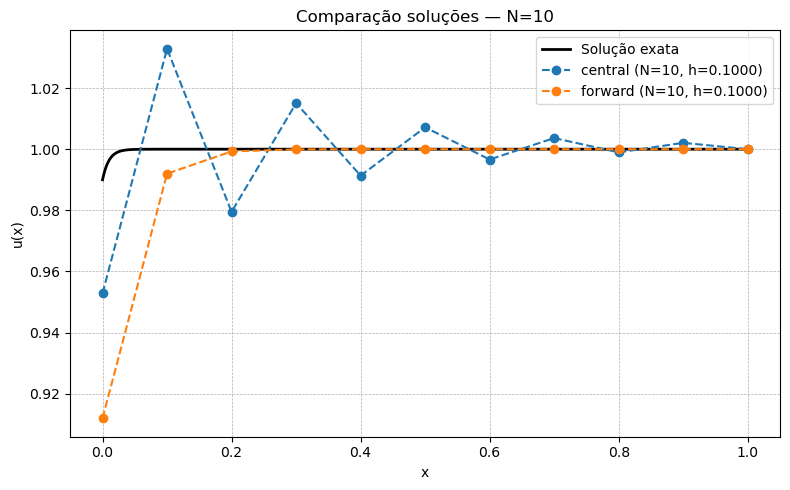

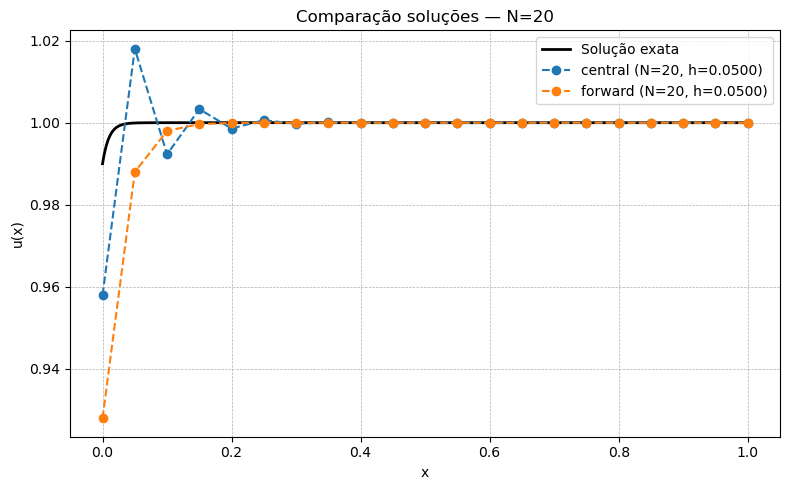

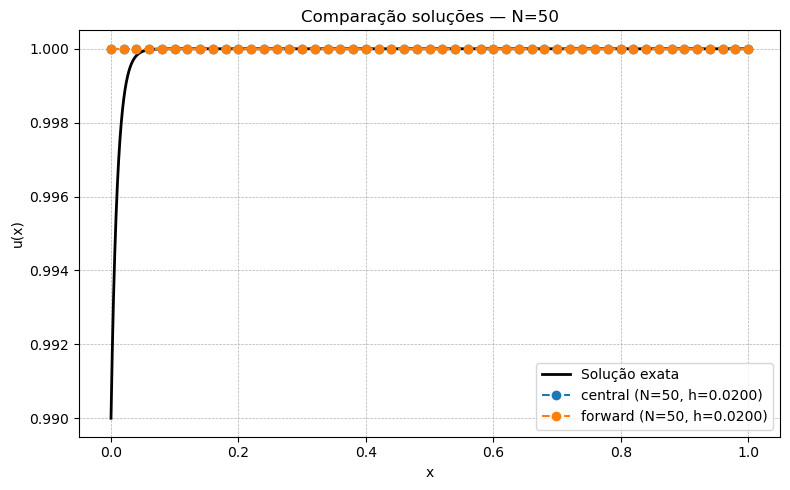

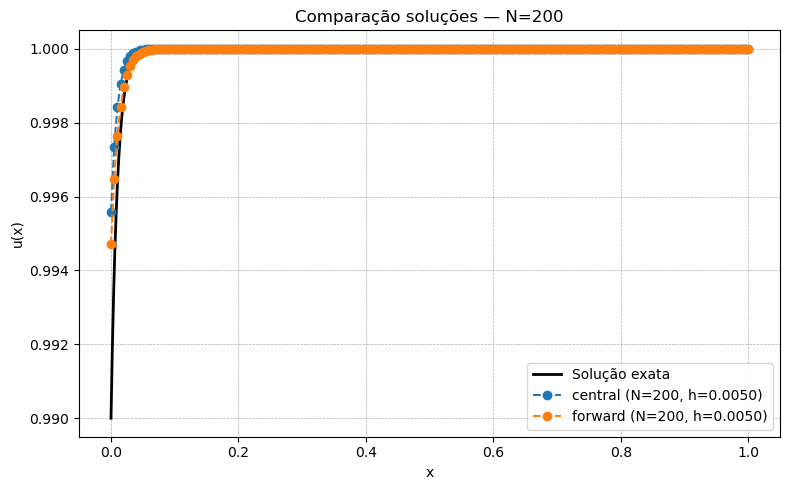

In [146]:
N_list = [10, 20, 50, 200]  
schemes = ['central', 'forward']

compare_and_plot(N_list, schemes)

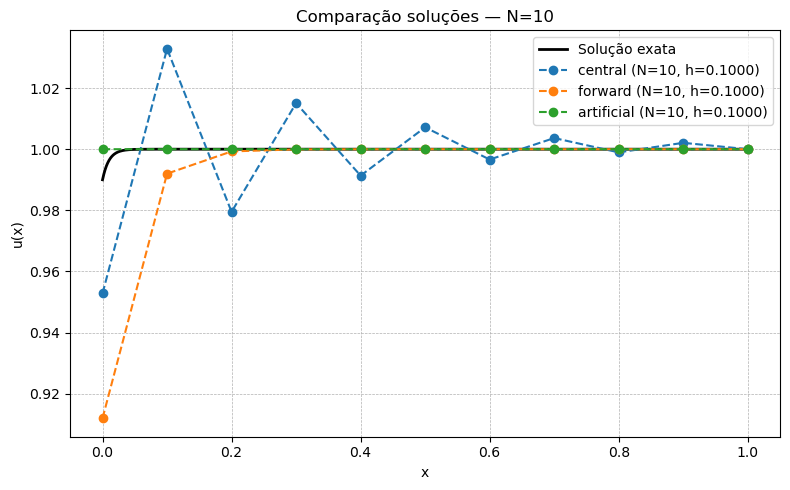

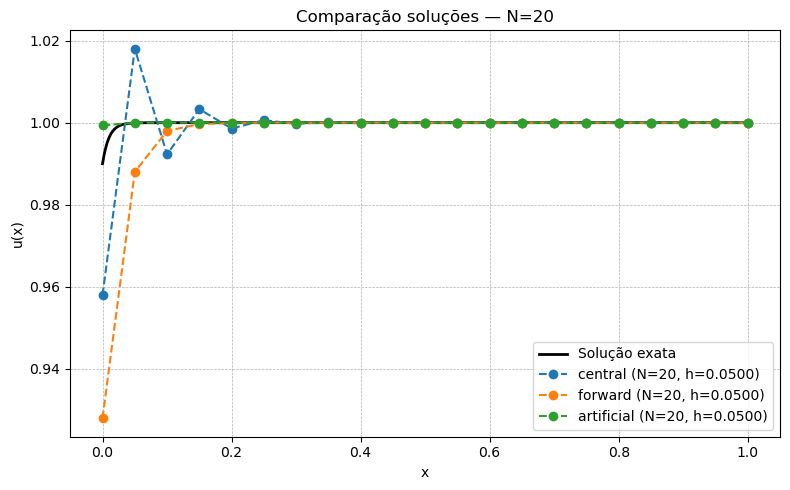

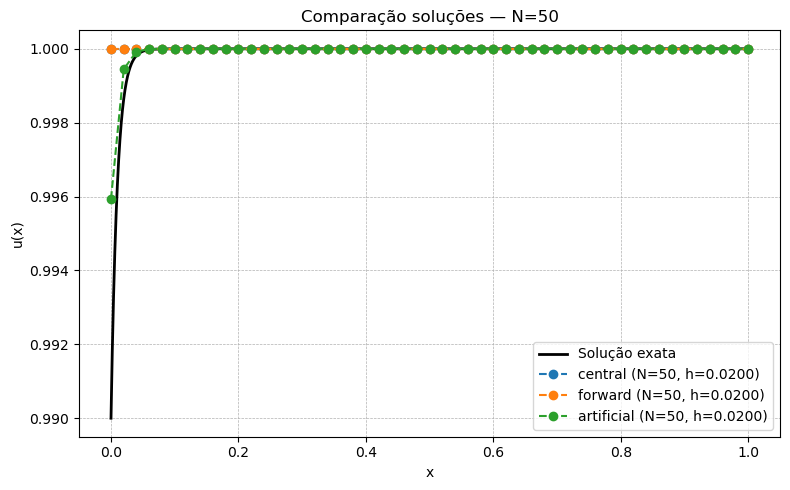

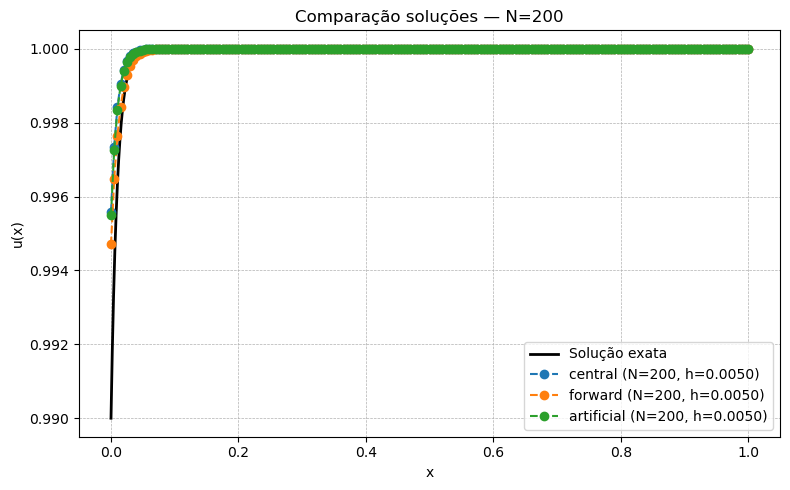

In [147]:
N_list = [10, 20, 50, 200]  
schemes = ['central', 'forward', 'artificial']

compare_and_plot(N_list, schemes)

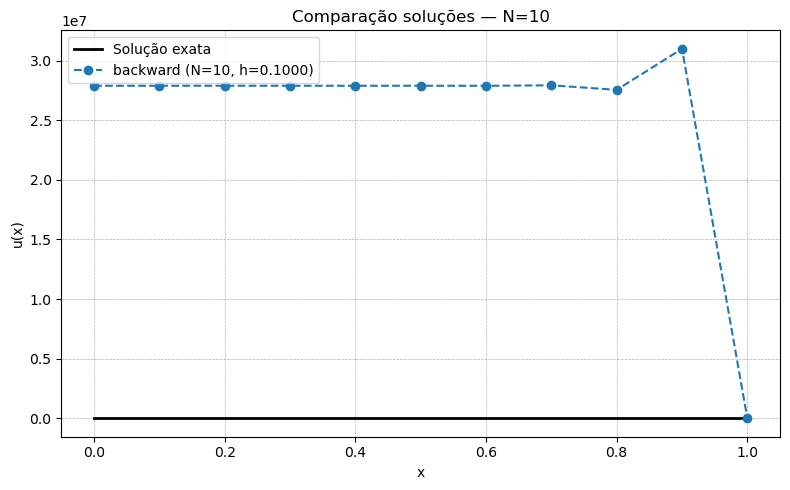

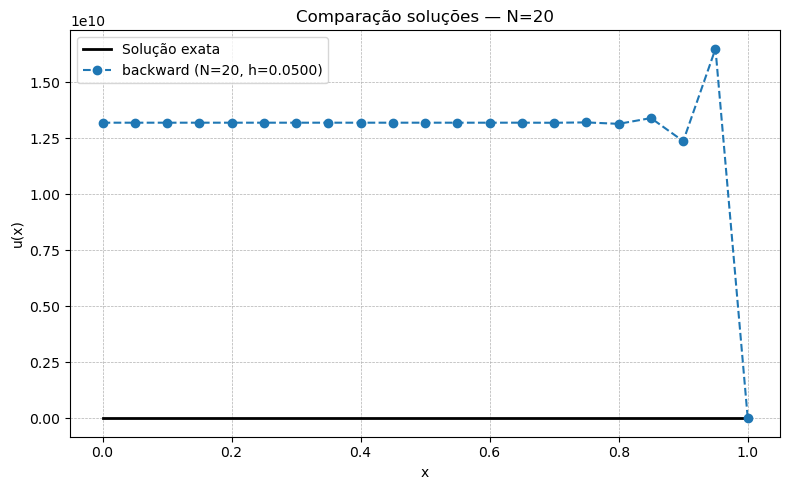

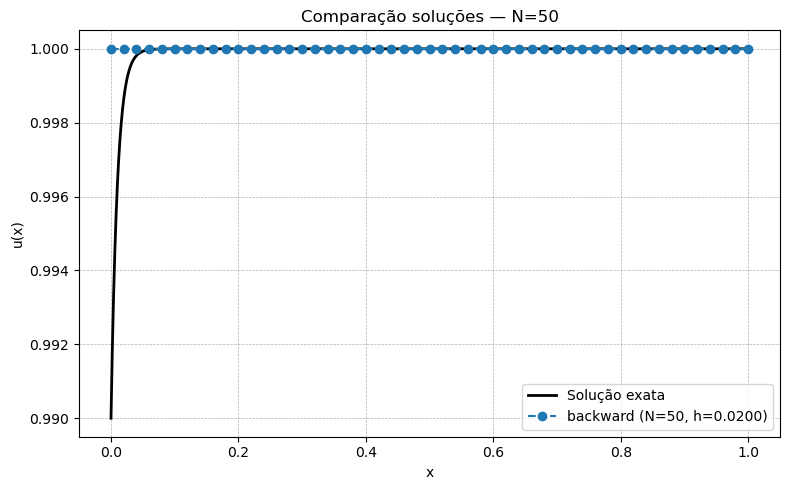

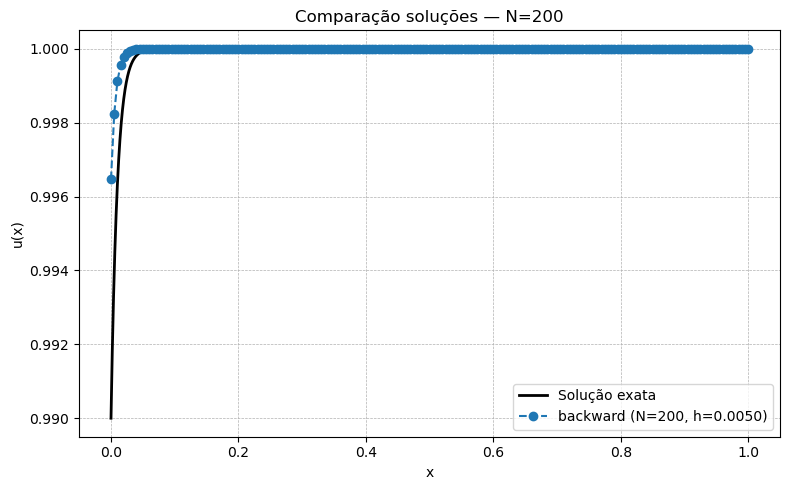

In [148]:
N_list = [10, 20, 50, 200]  
schemes = ['backward']

compare_and_plot(N_list, schemes)

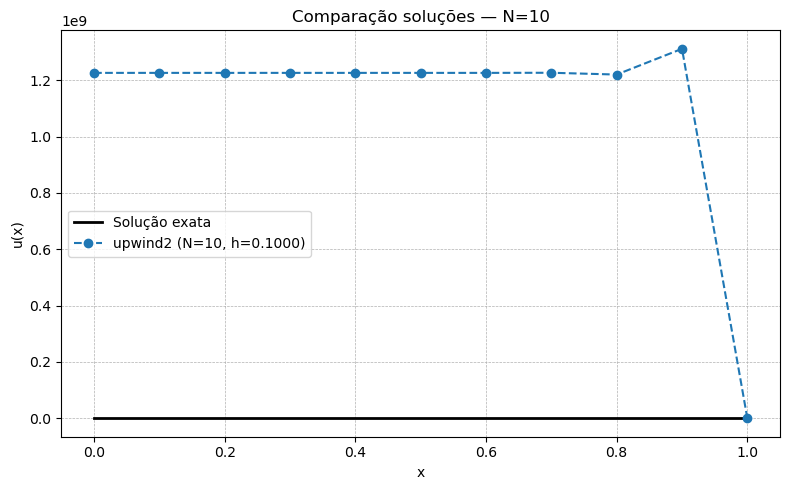

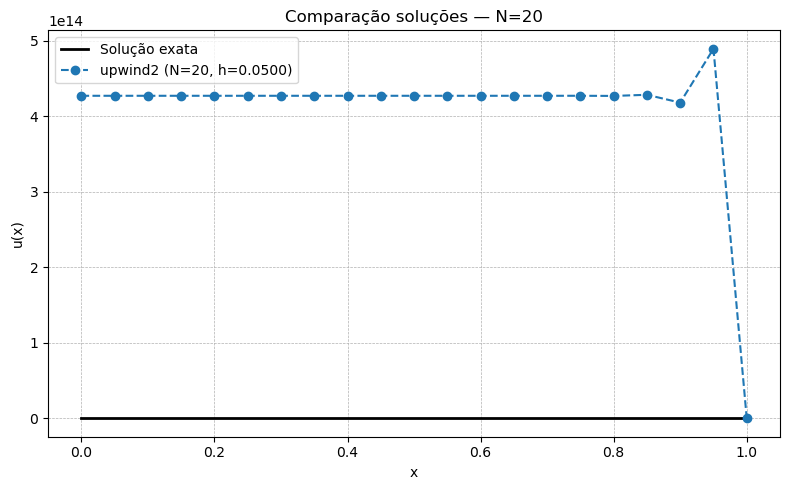

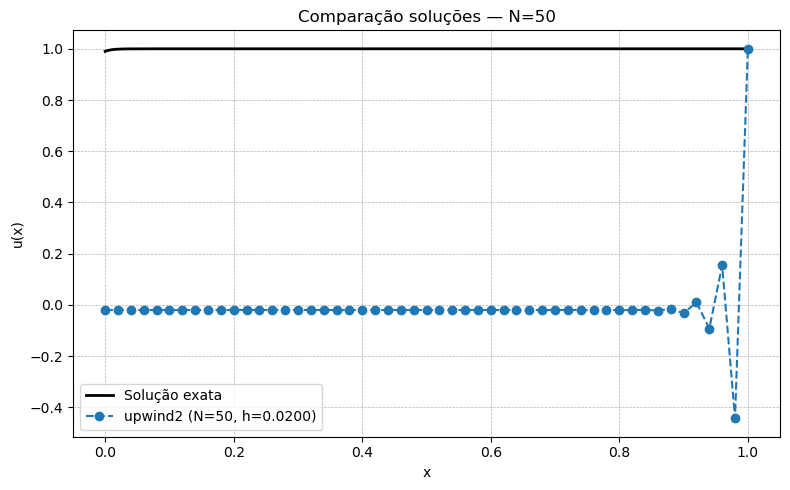

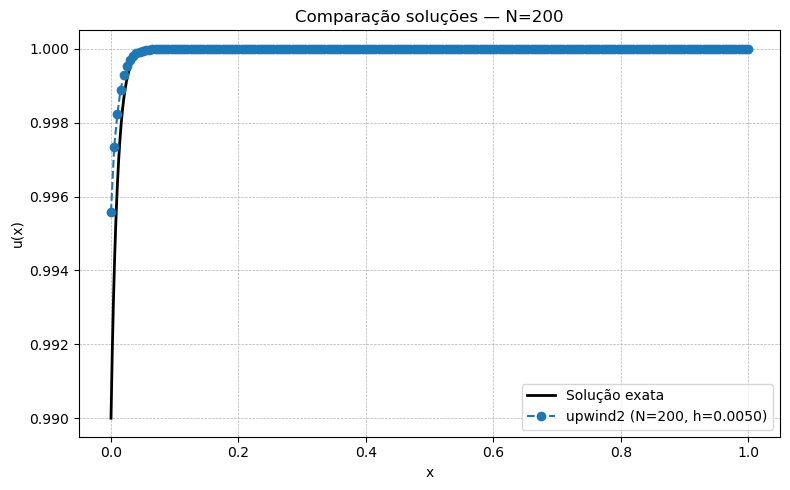

In [149]:
N_list = [10, 20, 50, 200]  
schemes = [ 'upwind2']

compare_and_plot(N_list, schemes)